# Lesson 3 - Exercise 1

1. Using the impedance measurement data `.csv` provided in [Lesson3-data in GitHub](https://github.com/ikuehirata/CodingSeminarCMBR/tree/master/lesson3-data,) fit the values to the formula
$$ Z = \frac{1}{j \omega C}$$
where $C = 2 \pi f$, $j$ is the imaginary number, and extract $C$ value.
The first column of the data is the frequency $f$, the second the impedance $Z$, the third the phase $\phi = \arg(Z)$.
Plot the experimental value in Bode plot. Add the fit value of $|Z|$.  
Hint: use the range range where the experimental fits the theoretical value.

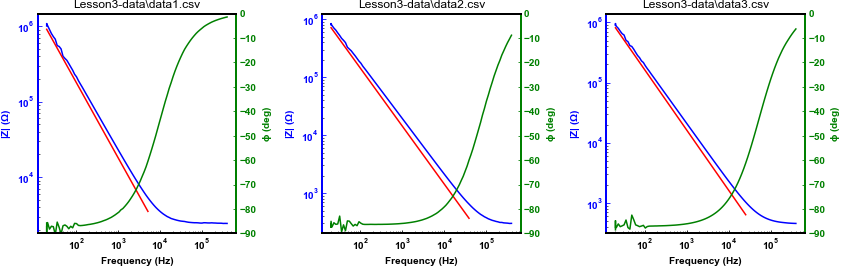

In [1]:
%matplotlib inline
import numpy as np
import glob
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=[12, 4])
def bodeplot(orgdata, fitdata, i):
    ax = axs[i]
    ax.plot(orgdata[:,0], orgdata[:,1], color="b")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f)
    ax2 = ax.twinx()
    ax2.plot(orgdata[:,0], orgdata[:,2], color="g")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("|Z| ($\Omega$)", color="b")
    ax.tick_params(axis="y",colors="b")
    ax2.spines['left'].set_color('b')
    ax2.set_ylabel("$\phi$ (deg)", color="g")
    ax2.tick_params(axis="y",colors="g")
    ax2.spines['right'].set_color('g')
    ax2.set_ylim((-90, 0))
    ax.plot(fitdata[:,0], fitdata[:,1], color="r")

cvalues = []
for (i, f) in enumerate(glob.glob("Lesson3-data/data*csv")):
    try:
        data = np.loadtxt(f, delimiter="\t", 
            usecols=[0,1,2])
        # Z = 1/j w C, log for Z and f for polynomial fitting
        # add fitting condition: where phase < -60 deg
        logfz = np.log([s[0:2] for s in data if s[2] < -60])
        # fitting
        p = P.polyfit(logfz[:,0], logfz[:,1], 1)
        c = np.exp(-1*p[0])/(2*np.pi)
        cvalues.append(c) # save parameter to a list
        fitz = p[0] - 1 * logfz[:,0]
        l = len(logfz)
        # rehape fit data into the same shape as original data
        fitdata = np.exp(np.concatenate((logfz[:,0].reshape(l, 1), 
            fitz.reshape(l, 1)), axis=1))
        # plot
        bodeplot(data, fitdata, i)
    except Exception as e:
        print(e)
plt.show()

2. The experimental value does not follow the theoretical value explicitly because of some parasite resistances. Capacitor model can be explained as
$$ Z = \frac{1}{j \omega C} // R_p + R_s $$
where $R_p$ is parallel resistance, $R_s$ series resistance, operator $//$
$$ a // b = \frac{1}{\frac{1}{a} + \frac{1}{b}}$$
, meaning a parallel circuit.
Plot the experimental value in Bode plot. Add the fit value of $|Z|$.  
Hint: if $R_p$ is huge, it can be ignored.

We cannot handle $R_p$ and $R_s$ at the same time. Let's treat one by one.

First, ignore $R_p$. When $f \rightarrow \infty$ we can cleary see the increase $\phi$. Since $Z$ is a complex value, we can subtract the imaginary part from $Z$ in the area where it is not negligible.

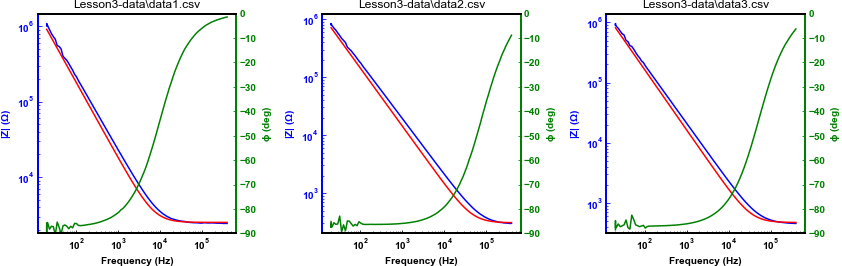

In [2]:
phithreshold = -70 # phi threshold value for Rs fitting. You can change as you prefer
rsvalues = []
fig, axs = plt.subplots(ncols=3, figsize=[12, 4])
for (i, f) in enumerate(glob.glob("Lesson3-data/data*csv")):
    try:
        data = np.loadtxt(f, delimiter="\t", usecols=[0,1,2])
        # get the average value of the real part where phase > -40 deg
        rs = np.average([s[1]*np.cos(s[2]/180*np.pi) for s in data if s[2] > phithreshold])
        rsvalues.append(rs)
        
        c = cvalues[i]
        fitz = abs(1/(-1j*2*np.pi*data[:,0]*c) + rs) # use j for complex number in Python
        l = len(fitz)
        fitdata = np.concatenate((data[:,0].reshape(l,1), 
            fitz.reshape(l,1)), axis=1)
        # plot
        bodeplot(data, fitdata, i)
    except Exception as e:
        print(e)
plt.show()

For $R_p$, it is recommended to calculate where $R_s$ can be ignored, i.e. $\omega \rightarrow 0$. In such case, $|Z|$ is described as
$$
\begin{align}
Z &= \frac{1}{j \omega C} // R_p \\
\frac{1}{Z} &= j \omega C + \frac{1}{R_p} \\
\frac{1}{|Z|} &= \sqrt{(\omega C)^2 + \frac{1}{R_p^2}} \\
\frac{1}{|Z|^2} &= \omega^2 C^2 + \frac{1}{R_p^2}
\end{align}
$$
therefore, $\frac{1}{|Z|^2}$ is a linear function of $f^2$.

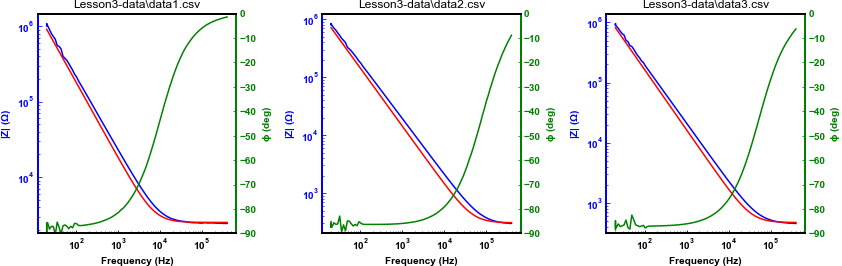

In [3]:
phithreshold = -70 # phi threshold value for Rs fitting. You can change as you prefer
rpvalues = []
fig, axs = plt.subplots(ncols=3, figsize=[12, 4])
for (i, f) in enumerate(glob.glob("Lesson3-data/data*csv")):
    try:
        data = np.loadtxt(f, delimiter="\t", usecols=[0,1,2])
        # create f^2 and 1/Z^2
        fit = np.asarray([[e[0]**2, 1/e[1]**2] for e in data if e[2] < phithreshold])
        # get the average value of the real part where phase < -70 deg
        p = P.polyfit(fit[:,0], fit[:,1], 1)
        rp = p[1]**(-1/2)
        rpvalues.append(rp)
        
        c = cvalues[i]
        rs = rsvalues[i]
        fitz = abs(1/((-1j*2*np.pi*data[:,0]*c)+1/rp) + rs) # use j for complex number in Python
        l = len(fitz)
        fitdata = np.concatenate((data[:,0].reshape(l,1), 
            fitz.reshape(l,1)), axis=1)
        # plot
        bodeplot(data, fitdata, i)
    except Exception as e:
        print(e)
plt.show()

3. Plot $C$ vs file name to visually compare the extracted C value.

$C$ values are stored in `cvalues`.

([<matplotlib.axis.XTick at 0x1a2a5d481c8>,
 <a list of 3 Text xticklabel objects>)

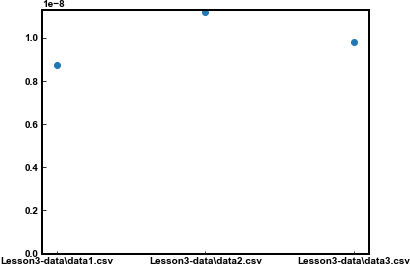

In [4]:
fig, ax = plt.subplots()
ax.plot(range(len(cvalues)), cvalues, "o")
plt.ylim(0,)
plt.xticks(range(3), glob.glob("Lesson3-data/data*csv"))

Note: `scipy` has a fitting function for non-polynomial functions [`optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).
You can further fit the values using this function. The time for fitting is faster or more accurate if you give initial values, which are obtained by the procedure above. If you cannot obtain the desired value, consider adding boundaries.

In [5]:
import time
from scipy.optimize import curve_fit
def zvalue(f, c, rs, rp):
     return np.abs(1/((-1j*2*np.pi*f*c)+1/rp) + rs)
data = np.loadtxt("Lesson3-data/data1.csv", delimiter="\t", usecols=[0,1])

print(f"Initial C, R_s, R_p are: {[cvalues[0], rsvalues[0], rpvalues[0]]}")

# curve_fit without initial values
start = time.time()
popt, pcov = curve_fit(zvalue, data[:,0], data[:,1])
end = time.time()
print(f"Without initial values the process took {end - start} s")
print(f"C, R_s, R_p are: {popt}")

# curve_fit with initial values
start = time.time()
popt, pcov = curve_fit(zvalue, data[:,0], data[:,1], p0=[cvalues[0], rsvalues[0], rpvalues[0]])
end = time.time()
print(f"With initial values the process took {end - start} s")
print(f"C, R_s, R_p are: {popt}")

Initial C, R_s, R_p are: [8.73636064260992e-09, 2514.3704573151836, 24762632.62056445]
Without initial values the process took 0.005995512008666992 s
C, R_s, R_p are: [-5.19205841e+01  1.73002097e+05 -5.19205841e+01]
With initial values the process took 0.004998207092285156 s
C, R_s, R_p are: [ 7.50039686e-09  2.76594903e+03 -5.77484343e+06]


C:\Users\Ikue\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
